In [19]:
%matplotlib inline
## imports

# site
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import flopy

# std
from pathlib import Path
import yaml

In [20]:
def read_array(rasterfile):
    with rasterio.open(rasterfile) as src:
        return src.read(masked=True)

In [21]:
## input

# name
name = 'test_dis_brabant'

# workspace
workspace = Path(r'..\output\dis')

# grid dimensions
nlay = 19
nrow = 450
ncol = 601
delr = 250.
delc = 250.

# data files
idomainfile = Path(r'..\data\boundary\ibound.tif')
topfile = Path(r'')

In [22]:
# read idomain
idomain = read_array(idomainfile)
print(idomain.shape)

(1, 450, 601)


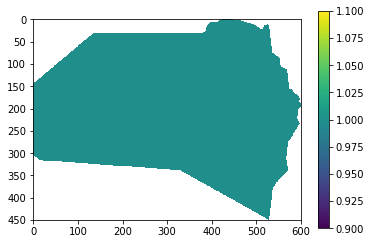

In [26]:
# show idomain
plt.imshow(idomain[0, :, :])
plt.colorbar()

In [ ]:
# read top and bot
top = read_array(topfile.format(1))
for ilay in range(nlay):
    
    

In [10]:
# create workspace directory
workspace.mkdir(exist_ok=True)

In [11]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    exe_name='mf6', 
    version='mf6',
    sim_ws=str(workspace))

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim,
    pname='tdis',
    time_units='DAYS',
    nper=1, 
    perioddata=[(1.0, 1, 1.0)],
    )

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.ModflowGwf(sim,
    modelname=name, 
   model_nam_file=model_nam_file,
   )

Directory structure already exists for simulation path C:\dev\mf6brabant\mf6brabant\notebooks\..\output\dis


In [ ]:
# initialize the DIS package
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf,
    pname='dis', nlay=nlay,
    nrow=nrow, ncol=ncol,
    delr=delr, delc=delc,
    top=top, botm=botm,
    idomain=idomain,
    )

In [ ]:
# write to package file
dis.write_file(check=False)